# I've said it before and I'll say it again - Relativity Matters

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import h5py
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
def process_h5_files(directory):
    X = []
    y = []
    for file in os.listdir(directory):
        if file.endswith(".h5"):
            filepath = os.path.join(directory, file)
            with h5py.File(filepath, "r") as f:
                # List all datasets in the file
                print(f"Datasets in {file}: {list(f.keys())}")
                
                for dataset_name in f.keys():
                    # Read the dataset (each sequence has variable length)
                    data = f[dataset_name][:]
                    label = file.split(".")[0]  # Extract label from filename
                    
                    # Append data and label
                    X.append(data)
                    y.append(label)

    # Return X as a list and y as a NumPy array
    return X, np.array(y)

dynamic_data_directory = 'data/static'
X, y = process_h5_files(dynamic_data_directory)

# Encode labels (convert to categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

Datasets in R.h5: ['R_0', 'R_1', 'R_10', 'R_100', 'R_101', 'R_102', 'R_103', 'R_104', 'R_105', 'R_106', 'R_107', 'R_108', 'R_109', 'R_11', 'R_110', 'R_111', 'R_112', 'R_113', 'R_114', 'R_115', 'R_116', 'R_117', 'R_118', 'R_119', 'R_12', 'R_120', 'R_121', 'R_122', 'R_123', 'R_124', 'R_125', 'R_126', 'R_127', 'R_128', 'R_129', 'R_13', 'R_130', 'R_131', 'R_132', 'R_133', 'R_134', 'R_135', 'R_136', 'R_137', 'R_138', 'R_139', 'R_14', 'R_140', 'R_141', 'R_142', 'R_143', 'R_144', 'R_145', 'R_146', 'R_147', 'R_148', 'R_149', 'R_15', 'R_150', 'R_151', 'R_152', 'R_153', 'R_154', 'R_155', 'R_156', 'R_157', 'R_158', 'R_159', 'R_16', 'R_160', 'R_161', 'R_162', 'R_163', 'R_164', 'R_165', 'R_166', 'R_167', 'R_168', 'R_169', 'R_17', 'R_170', 'R_171', 'R_172', 'R_173', 'R_174', 'R_175', 'R_176', 'R_177', 'R_178', 'R_179', 'R_18', 'R_180', 'R_181', 'R_182', 'R_183', 'R_184', 'R_185', 'R_186', 'R_187', 'R_188', 'R_189', 'R_19', 'R_190', 'R_191', 'R_192', 'R_193', 'R_194', 'R_195', 'R_196', 'R_197', 'R_19

In [3]:
# Split the data
X = np.array(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=132, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=432, shuffle=True)


In [4]:
#Define model using convolutional neural network (CNN)
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, padding = 'same'))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=3, activation='relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2, padding = 'same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model
    

In [5]:
# Get the input shape from the data
input_shape = X_train.shape[1:] # Shape of a single sample
num_classes = y_encoded.shape[1] # Number of classes

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Input shape: (1, 88)
Number of classes: 24


In [6]:
# Create the model
model = create_model(input_shape, num_classes)

# Learning Rate Scheduler & Early Stopping to optimize training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stopping], verbose=1)

Epoch 1/100


/Users/cardinal/Documents/GitHub/csci218-group-project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1389 - loss: 4.7188 - val_accuracy: 0.5705 - val_loss: 1.3390 - learning_rate: 0.0010
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.4485 - loss: 1.6663 - val_accuracy: 0.6983 - val_loss: 0.8601 - learning_rate: 0.0010
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5567 - loss: 1.2955 - val_accuracy: 0.7228 - val_loss: 0.7732 - learning_rate: 0.0010
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6161 - loss: 1.1003 - val_accuracy: 0.7908 - val_loss: 0.6481 - learning_rate: 0.0010
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6445 - loss: 1.0084 - val_accuracy: 0.8114 - val_loss: 0.5554 - learning_rate: 0.0010
Epoch 6/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6698 - loss: 0.9294 - val_accuracy: 0.7963 - val_loss: 0.5837 - learning_rate: 0.0010
Epoch 7/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6788 - loss: 0.90

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,818 (718.04 KB)

 Trainable params: 61,272 (239.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 122,546 (478.70 KB)

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - accuracy: 0.9586 - loss: 0.1341
Test Accuracy: 0.9607672095298767


In [9]:
# Save the model
model.save('models/static_cnn.keras')

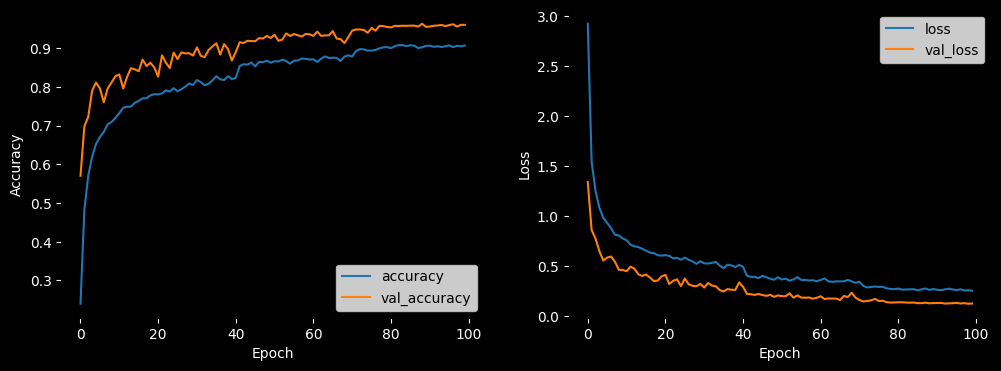

In [10]:
# Visualize training results
plt.figure(figsize=(12, 4))

# Accuracy plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch', color='white')
ax1.set_ylabel('Accuracy', color='white')
ax1.legend(loc='lower right')
ax1.tick_params(colors='white', which='both')
plt.setp(ax1.get_xticklabels(), color='white')
plt.setp(ax1.get_yticklabels(), color='white')
ax1.set_facecolor('black')

# Loss plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epoch', color='white')
ax2.set_ylabel('Loss', color='white')
ax2.legend(loc='upper right')
ax2.tick_params(colors='white', which='both')
plt.setp(ax2.get_xticklabels(), color='white')
plt.setp(ax2.get_yticklabels(), color='white')
ax2.set_facecolor('black')

# Set the figure background to black
plt.gcf().set_facecolor('black')

plt.show()

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


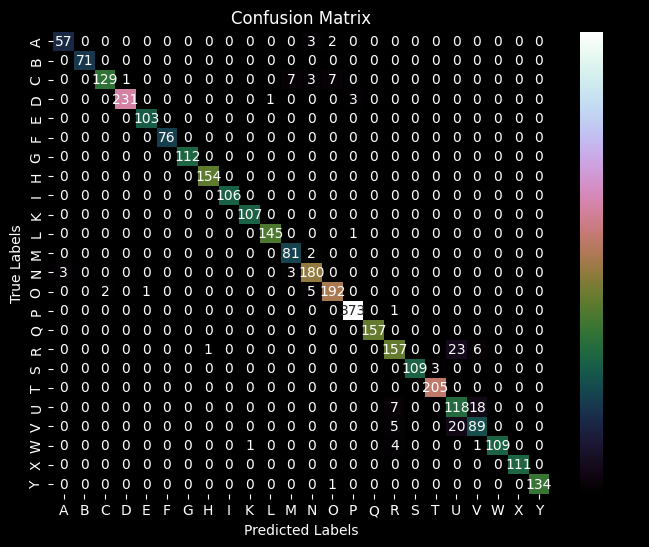

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming y, y_test, and model are already defined
y_test_labels = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Extract unique labels from y_test_labels and y_pred
unique_labels = np.unique(np.concatenate((y_test_labels, y_pred)))

# Set original_labels to the unique labels in y
original_labels = list(set(y))

# Fit the label encoder on the original labels
label_encoder = LabelEncoder()
label_encoder.fit(original_labels)

# Convert numerical labels back to original string labels
unique_labels_str = label_encoder.inverse_transform(unique_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='cubehelix', fmt='d', xticklabels=unique_labels_str, yticklabels=unique_labels_str)

# Set the plot background to black
plt.gcf().set_facecolor('black')
ax.set_facecolor('black')

# Change text color to white
ax.tick_params(colors='white', which='both')  # Change color of ticks
plt.setp(ax.get_xticklabels(), color='white')  # Change color of x-axis labels
plt.setp(ax.get_yticklabels(), color='white')  # Change color of y-axis labels
plt.title('Confusion Matrix', color='white')
plt.xlabel('Predicted Labels', color='white')
plt.ylabel('True Labels', color='white')

plt.show()

[15 21 17 ...  3  8  9]
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


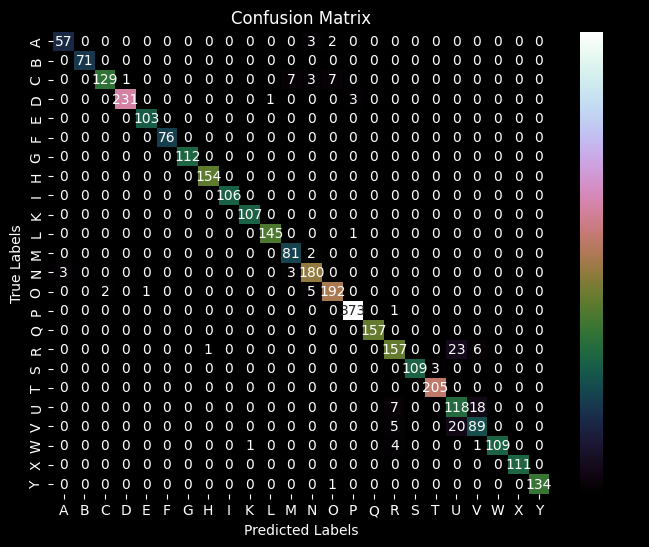

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)

# Get the predicted labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot the confusion matrix using seaborn
labels = label_encoder.classes_
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='cubehelix', fmt='d', xticklabels=labels, yticklabels=labels)

# Set the plot background to black
plt.gcf().set_facecolor('black')
ax.set_facecolor('black')

# Change text color to white
ax.tick_params(colors='white', which='both')  # Change color of ticks
plt.setp(ax.get_xticklabels(), color='white')  # Change color of x-axis labels
plt.setp(ax.get_yticklabels(), color='white')  # Change color of y-axis labels
plt.title('Confusion Matrix', color='white')
plt.xlabel('Predicted Labels', color='white')
plt.ylabel('True Labels', color='white')

plt.show()